Parasite has Cancer? (Efficient):  False


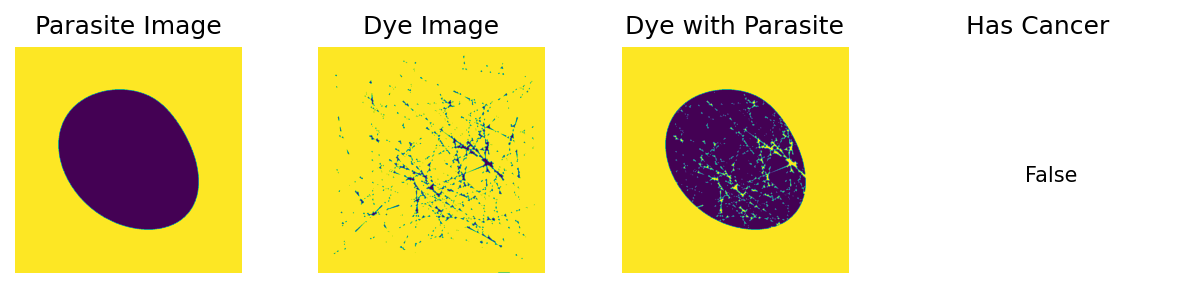

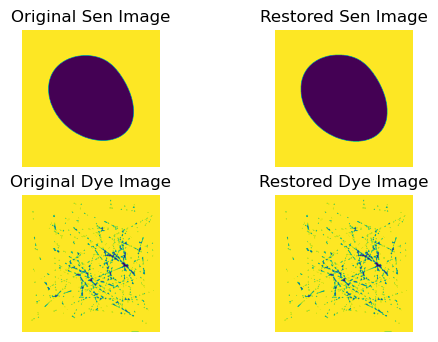

In [1]:
import cv2
import cmath
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.spatial import ConvexHull

###################### Creating random Convex Hull ######################    

def CreateConvexHullShape(globularity=0.5):
    
    # The interpolation idea is based on taking the FFt, then leaving the low frequencies as they 
    # are, padding with zeros at high frequencies, and taking an inverse FFT.
    def interpolateSmoothly(xs, N):
        # For each point, add N points more points
        fs = fft(xs)
        half = (len(xs) + 1) // 2
        fs2 = list(fs[:half]) + [0]*(len(fs)*N) + list(fs[half:])
        return [x.real / len(xs) for x in fft(fs2)[::-1]]

    # getting x and y coordinates from an imaginary number
    def point(x):
        return (x.real,x.imag)
    
    # genrating random points on a 2d plane to form a Convex Hull
    # higher globularity will space out the random points
    randPts = [point((np.random.rand() + globularity) * cmath.exp(2j*np.pi*i/7)) for i in range(7)]

    # getting the convex hull from the points
    hull = ConvexHull(randPts)
    globPts = [tuple(randPts[s]) for s in hull.vertices]

    # smoothing the convex hull 
    xs, ys = [interpolateSmoothly(zs, 100) for zs in zip(*globPts)]

    return randPts,xs,ys


###################### Creating the Blob image ######################

def CreateParasiteImage(width,height,xs,ys):
    
    minRad = np.sqrt(0.25/np.pi)
    maxRad = 0.5 

    # creating the base blank image
    blobImag = np.zeros((height,width), np.uint8)

    # random radius of the blob (assuming a circular boundary)
    # ranging from min-radius to max radius of 0.5 (scaled to 1)
    rad = np.random.rand()*(maxRad-minRad) + minRad 

    # maximum size of the blob will range from 0.05 to 0.95 
    # across the image
    blobRange = [0.55-rad,0.45+rad]

    # scale the blob coordinates to blobRange
    def rescale(lst):
        ma = max(lst)
        mi = min(lst)
        return map(lambda x: blobRange[0] + (float(x)-mi)/(ma-mi)*(blobRange[1]-blobRange[0]), lst)

    # converting the interpolated graph points xs,ys to pixed coordintes in blobBoundary
    blobBoundary = [(int(x*width),int(y*height)) for x,y in zip(rescale(xs),rescale(ys))]

    # sorting the blobBoundary coordinates by row and then by column
    blobBoundary.sort()

    # filling in the boundary locations on the base image which will
    # act as a seed for the blob boundary
    for i in blobBoundary:
        blobImag[i[0]][i[1]] = 255
    
    # dilating the discontinuous low density image to make the blob 
    # boundary more clear
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (width//100,height//100))
    blobImag = cv2.dilate(blobImag, kernel, iterations=1)

    # floodfilling the image starting at the center (within the blob)
    cv2.floodFill(blobImag, None, (width//2,height//2), 255)

    # inverting the image so that the blob locations are 0 and the 
    # surroundings are 255 value
    blobImag = cv2.bitwise_not(blobImag)
    
    return blobImag


###################### Creating the Dye image ######################

def CreateDyeImage(width, height):
    # creating the base blank image
    dyeImag = np.zeros((height,width), np.uint8)

    # creating random lines to seed the "blood vessels" in the parasite
    for i in range(100):
        r1,r2 = np.random.randint(height,size=2)
        c1,c2 = np.random.randint(width,size=2)
        cv2.line(
                  dyeImag,
                  pt1 = (r1,c1), pt2 = (r2,c2),
                  color = 255,
                  thickness = 1
                )
    
    # creating a random variable for the strength of dye. This will ensure at max 0.1% 
    # of the cases will have cancer. Iteration of 4 is very high dye strength and always 
    # results in more than 10% of the body region as dyed.
    dyeStrength = np.random.choice([1,2,3,4], p=[0.399,0.6,0.0002,0.0008])
    
    # applying a 'close' morphology operation to bold the vascular network 
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (width//220,height//220))
    dyeImag = cv2.morphologyEx(dyeImag, cv2.MORPH_CLOSE, kernel, iterations=dyeStrength)
    
    # applying a 'erode' morphology operation to reduce the thickness of
    # the vessels
    dyeImag = cv2.morphologyEx(dyeImag, cv2.MORPH_ERODE, kernel)

    # inveting the image so that the blob locations are 0 and the 
    # surroundings are 255 value
    dyeImag = cv2.bitwise_not(dyeImag)

    return dyeImag

###################### Detecting Cancer from image ######################

def hasCancer(sensImage, dyeImage):
    pixParasite, countParasite = np.unique(sensImage, return_counts=True)
    pixDyeInParasite, countDyeInParasite = np.unique(cv2.bitwise_or(sensImage,dyeImage), return_counts=True)

    return bool(100 * countDyeInParasite[pixDyeInParasite==0] / countParasite[pixParasite==0] > 10)


def hasCancerEfficient(sensImage, dyeImage):
    countParasite = np.sum(sensImage==0)
    countDyeInParasite = np.sum(cv2.bitwise_or(sensImage,dyeImage)==0)
    
    return bool(100 * countDyeInParasite / countParasite > 10)

###################### Main Program ######################

if __name__=='__main__':
    
    width = int(1e3)
    height = int(1e3)
    numShow = 1
    
    # initializing variable to store simulated sensor image and dye image
    sensorImage, dyeImage = None, None
    
    if numShow>1:
        # setting up the subplots
        f, axes = plt.subplots(numShow,4,figsize=(10, 10))
        f.set_dpi(150)
        axes[0][0].set_title("Parasite Image")
        axes[0][1].set_title("Dye Image")
        axes[0][2].set_title("Dye with Parasite") 
        axes[0][3].set_title("Has Cancer") 

        for n in range(numShow):

            # generating a convex hull of random points to create a blob shape
            # globularity defines the roundness of the glob generated ranging from 0 to inf
            _,xs,ys = CreateConvexHullShape(globularity=2)

            # generating sensor image and dye image of desired resolution 
            # using the blob shape
            sensorImage = CreateParasiteImage(width,height,xs,ys)
            dyeImage = CreateDyeImage(width,height)

            ########### Plotting the resulting images ###########

            # note that the images displayed are resized just for display purpose
            axes[n][0].imshow(cv2.resize(sensorImage, (1000, 1000)))
            axes[n][0].axis('off')

            axes[n][1].imshow(cv2.resize(dyeImage, (1000, 1000)))
            axes[n][1].axis('off')

            dyeInParasite = cv2.bitwise_or(sensorImage,dyeImage)
            dyeWithParasite = cv2.bitwise_or(sensorImage,cv2.bitwise_not(dyeInParasite))
            axes[n][2].imshow(cv2.resize(dyeWithParasite, (1000, 1000)))
            axes[n][2].axis('off')

            axes[n][3].text(0.45,0.4, str(hasCancer(sensorImage,dyeImage)))
            axes[n][3].axis('off')
    
    else:
        _,xs,ys = CreateConvexHullShape(globularity=1)
        sensorImage = CreateParasiteImage(width,height,xs,ys)
        dyeImage = CreateDyeImage(width,height)
            
        f, axes = plt.subplots(numShow,4,figsize=(10, 2))
        f.set_dpi(150)
        axes[0].set_title("Parasite Image")
        axes[1].set_title("Dye Image")
        axes[2].set_title("Dye with Parasite") 
        axes[3].set_title("Has Cancer")
        axes[0].imshow(cv2.resize(sensorImage, (1000, 1000)))
        axes[0].axis('off')

        axes[1].imshow(cv2.resize(dyeImage, (1000, 1000)))
        axes[1].axis('off')

        dyeInParasite = cv2.bitwise_or(sensorImage,dyeImage)
        dyeWithParasite = cv2.bitwise_or(sensorImage,cv2.bitwise_not(dyeInParasite))
        axes[2].imshow(cv2.resize(dyeWithParasite, (1000, 1000)))
        axes[2].axis('off')

        axes[3].text(0.45,0.4, str(hasCancer(sensorImage,dyeImage)))
        axes[3].axis('off')
    
    # The last generated image is used for further computations
    
    ## Compressing and Restoring the simulated Sensor and Dye Image
    
    # thresholding the input images to make sure it is in binary format
    _, sensorThresh = cv2.threshold(sensorImage, 127, 255, cv2.THRESH_BINARY_INV)
    _, dyeThresh = cv2.threshold(dyeImage, 127, 255, cv2.THRESH_BINARY_INV)

    sensorCompress = {}

    # use morph gradient to extract the edge of the parasite blob.
    # This will reduce the number of iterations in each row of the image while compressing
    sensorBound = cv2.morphologyEx(sensorThresh, cv2.MORPH_GRADIENT, np.ones((width//100, height//100), np.uint8))
    
    # Compressing the sensor image
    for i in range(np.shape(sensorBound)[0]):
        for j in range(np.shape(sensorBound)[1]):
            if sensorBound[i][j]==0: continue
            if i not in sensorCompress:
                # initializing each row
                sensorCompress[i] = [width,0]
            sensorCompress[i][0] = min(sensorCompress[i][0],j)
            sensorCompress[i][1] = max(sensorCompress[i][1],j)
    
    dyeCompress = np.empty((2, 0), np.uint32)
    
    # Compressing the dye image
    for i in range(np.shape(dyeImage)[0]):
        for j in range(np.shape(dyeImage)[1]):
            if dyeImage[i][j]==255: continue
            dyeCompress = np.append(dyeCompress, np.array([[i,j]],np.uint32).transpose(), axis=1)
            
            
    ########### Restoring image from data structure ###########

    genSensorImage = np.zeros((height,width), np.uint8) + 255

    for r,c in sensorCompress.items():
        genSensorImage[r][c[0]:c[1]] = 0
            
    genDyeImage = np.zeros((height,width), np.uint8) + 255

    for r,c in zip(dyeCompress[0],dyeCompress[1]):
        genDyeImage[r][c] = 0
        
    ########### Plotting the original vs restored ###########

    f, axes = plt.subplots(2,2)
    f.set_dpi(100)
    
    # note that the images displayed are resized just for display purpose
    axes[0][0].imshow(cv2.resize(sensorImage, (1000, 1000)))
    axes[0][0].set_title("Original Sen Image")
    axes[0][0].axis('off')

    axes[0][1].imshow(cv2.resize(genSensorImage, (1000, 1000)))
    axes[0][1].set_title("Restored Sen Image")
    axes[0][1].axis('off')
    
    axes[1][0].imshow(cv2.resize(dyeImage, (1000, 1000)))
    axes[1][0].set_title("Original Dye Image")
    axes[1][0].axis('off')

    axes[1][1].imshow(cv2.resize(genDyeImage, (1000, 1000)))
    axes[1][1].set_title("Restored Dye Image")
    axes[1][1].axis('off')
    
    #####################################################################################
    
    print("Parasite has Cancer? (Efficient): ", hasCancerEfficient(sensorImage,dyeImage))
    